# Классификация токсичных комментариев

Интернет-магазин запускает сервис, в котором пользователи могут редактировать и дополнять описания товаров, то есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Дообучим модель для решения задачи с значением метрики качества *F1* не меньше 0.75.

*Описание данных опущено в связи с ограничениями на использование

## Подготовка

In [1]:
# Importing libraries
# ! pip install pytorch-transformers
# ! pip install keras
# ! pip install transformers

import re
import warnings
import tqdm
from tqdm.notebook import tqdm


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
)

import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AdamW,
)
from keras.utils import pad_sequences
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler,
    WeightedRandomSampler,
)

from IPython.display import clear_output

warnings.filterwarnings("ignore", category=UserWarning)
plt.style.use('dark_background')
tqdm.pandas()

In [2]:
# Checking for GPU availability and choosing a device for computing
if torch.cuda.is_available():
  print('Есть GPU')
else:
  print('Нет GPU, будем работать на CPU')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu") # CPU device
torch.cuda.device(device) # Activation of the selected device

Есть GPU


In [3]:
# Variable for fixing randomness
RANDOM_STATE = 42

In [5]:
# Upload the data
try:
  data = pd.read_csv('/content/toxic_comments.csv', index_col=0)
except:
  data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [6]:
# Размерность данных
data.shape

(159292, 2)

In [7]:
# Посмотрим на данные
data.sample(5)

,text,toxic
99530,I am certainly willing to give it a try; we'll...,0
51076,Italian colonisation of the Americas \n\nHi Re...,0
42294,In Group A Canada can NOT win the group with t...,0
94820,"""PPS: If the relevance of the Insubres here is...",0
112051,Everything in that sentence is stated somewher...,0


In [8]:
# Проверим значения таргета
data.toxic.value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

In [9]:
# сразу возьмем 10% данных, чтобы уменьшить вычисления
df, _ = train_test_split(
    data, train_size=.1,
    stratify=data['toxic'],
    random_state=RANDOM_STATE)

In [10]:
# Очистка текста от почт, символов и ссылок
def clean_text(text):
    # Удаление ссылок
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Удаление адресов электронной почты
    text = re.sub(r'\S+@\S+', '', text)
    # Удаление символов, оставляя только буквы и пробелы
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [11]:
# Применение функции clean_text() к столбцу 'text'
df['clear_text'] = df['text'].progress_apply(clean_text)

  0%|          | 0/15929 [00:00<?, ?it/s]

In [12]:
# Разобьем данные по векторам и разметим текст
sentences, labels = df['clear_text'].values, df['toxic'].values

sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [13]:
# Проверим разметку
sentences[666]

'[CLS] Politically Correct Info Abounds Needs Work [SEP]'

In [14]:
# Проверяем, что количество предложений, меток и строк в DataFrame совпадает
assert len(sentences) == len(labels) == df.shape[0], \
    "Количество предложений и меток в DataFrame не совпадает"

In [15]:
# Разобьем данные на тренировочную и тестовую выборки с сохранением баланса таргета
(
    train_sentences,
    test_sentences,
    train_y, test_y )= train_test_split(
        sentences, labels,
        random_state=RANDOM_STATE,
        train_size=.9,
        stratify=labels)

In [16]:
# Посмотрим размер выборок
print(f'Размер тренировочной выборки: {len(train_y)}',
      f'\nРазмер тестовой выборки: {len(test_y)}')

Размер тренировочной выборки: 14336 
Размер тестовой выборки: 1593


In [17]:
# Проверим баланс
print('Доли классов в тренировочной и тестовой выборках: \n', '*'*48)

for data in [train_y, test_y]:
# Подсчет количества уникальных значений
  counts = np.bincount(data)

  # Вычисление долей
  fractions = counts / len(data)

  # Вывод долей
  for i, fraction in enumerate(fractions):
      print(f"Доля класса {i}: {fraction:.3f}")

  print('*' * 34)

Доли классов в тренировочной и тестовой выборках: 
 ************************************************
Доля класса 0: 0.898
Доля класса 1: 0.102
**********************************
Доля класса 0: 0.898
Доля класса 1: 0.102
**********************************


In [18]:
# Проверим совпадение индексов
train_y[10:15]

array([0, 0, 0, 0, 0])

In [19]:
# Проверим совпадение индексов
train_sentences[10:15]

['[CLS] And what about bravery Could someone clarify it in this article or is it merely a Wiktionary topic [SEP]',
 '[CLS] REDIRECT TalkLark Quarry Dinosaur Trackways [SEP]',
 '[CLS] OK add here the information and we add it to the article mabdul [SEP]',
 '[CLS] look back at the page for deletion page u just posted stuff at [SEP]',
 '[CLS] In Sports Iraklis Thessaloniki is named after him and several other clubs in Greece and CyprusAlso IN Holland they ahve a team called Hercules and there is a team called Heracles in SpainWe should add this too i think [SEP]']

Все отлично!

In [20]:
# Теперь токенизируем наши тексты
tokenizer = BertTokenizer.from_pretrained(
    "unitary/toxic-bert",
    do_lower_case=True,)

tokenized_texts = [tokenizer.tokenize(sent) for sent in tqdm(train_sentences)]

  0%|          | 0/14336 [00:00<?, ?it/s]

In [21]:
print(tokenized_texts[0])

['[CLS]', 'officials', '##ix', '##si', '##x', '##si', '##x', 'hi', 'you', 'may', 'want', 'to', 'rev', '##isi', '##t', 'this', 'one', '[SEP]']


In [22]:
# Получим размер самого большого вектора для установки паддинга
n = 256
max(map(len, tokenized_texts))

1876

In [23]:
# Паддинг и атеншен маска
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=n,
    dtype='long',
    truncating='post',
    padding='post'
)
attension_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [24]:
# Разделим дополнительно тренировочную выборку с валидационной
(
    train_inputs,
    val_inputs,
    train_labels,
    val_labels) = train_test_split(
        input_ids, train_y,
        random_state=RANDOM_STATE,
        train_size=.9)

train_masks, val_masks, _, _ = train_test_split(
    attension_masks,
    input_ids,
    random_state=RANDOM_STATE,
    train_size=.9,
)

In [25]:
# Преобразуем векторы в тензоры
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [26]:
val_inputs = torch.tensor(val_inputs)
val_labels = torch.tensor(val_labels)
val_masks = torch.tensor(val_masks)

In [27]:
train_inputs

tensor([[  101, 16215,  2595,  ...,     0,     0,     0],
        [  101, 17012,  2008,  ...,     0,     0,     0],
        [  101, 13292, 11396,  ...,     0,     0,     0],
        ...,
        [  101,  3100,  1045,  ...,  1999,  2087,  2060],
        [  101,  2182,  2015,  ...,     0,     0,     0],
        [  101,  2281, 11396,  ...,     0,     0,     0]])

In [28]:
# создаем тренировочный даталоадер
class_counts = torch.bincount(train_labels).tolist()
weights = [1.0 / count for count in class_counts]

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=WeightedRandomSampler(weights, num_samples=len(train_data), replacement=True),
    batch_size=14
)

In [29]:
# создаем валидационный даталоадер
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(
    val_data,
    sampler=SequentialSampler(val_data),
    batch_size=14
)

### Промежуточный вывод:

Провели первичный анализ и предобработку данных:
+ взяли часть данных для исследования
+ Очистили и разметили корпус
+ токенизировали, преобразовали в паддинг, создали аттеншен маску
+ разделили данные на тренировочный и валидационный корпусы
+ преобразовали векторы в тензоры и создали даталоадеры

Готовы к исследованию модели Bert

## Обучение

In [30]:
# модель берт
model = BertForSequenceClassification.from_pretrained(
    'unitary/toxic-bert',
    ignore_mismatched_sizes=True,
    num_labels=2)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at unitary/toxic-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [31]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': .03},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': .0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


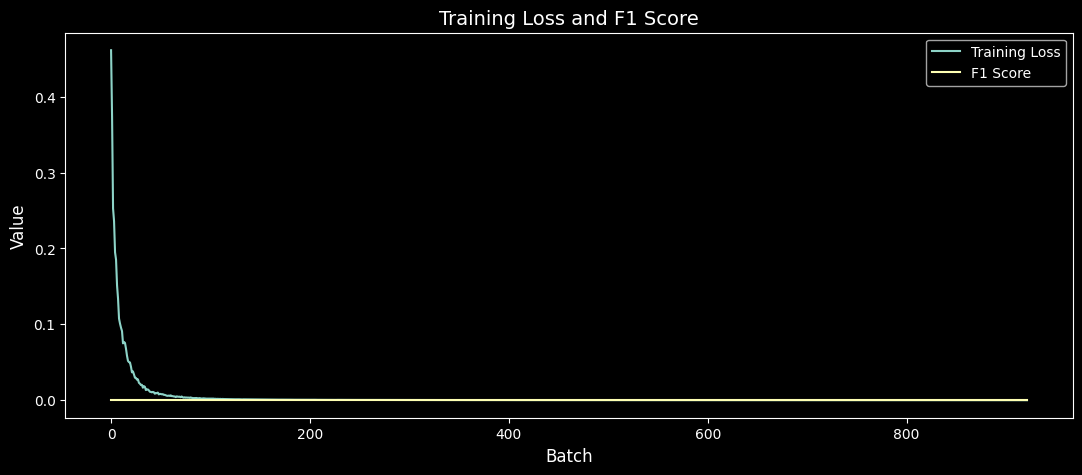


Loss на обучающем корпусе: 3.87498


  0%|          | 0/103 [00:00<?, ?it/s]

In [32]:
criterion = torch.nn.CrossEntropyLoss()

train_loss_set = []
train_preds, train_y = [], []
f1_score_set = []
val_preds, val_y = [], []

train_loss = 0
num_epochs = 1
# Переменные для ранней остановки
best_val_loss = float('inf')  # Лучшая ошибка на валидационных данных
# Страховка на большом количестве эпох
epochs_without_improvement = 0  # Количество эпох без улучшений
patience = 1  # Порог без улучшений для ранней остановки

# Переводим модель в training_mode
model.train()

%matplotlib inline
for epoch in range(num_epochs):  # Замените num_epochs на ваше значение
    for step, batch in tqdm(enumerate(train_dataloader)):
        # Добавляем батч для вычисления device
        batch = tuple(t.to(device) for t in batch)
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        # Forward loss
        logits = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask)

        loss = criterion(logits[0], b_labels)
        train_loss_set.append(loss.item())

        # Вычисляем метрику F1
        train_batch_preds = torch.argmax(logits[0], axis=1).cpu().numpy()

        train_preds.extend(train_batch_preds)
        train_y.extend(b_labels.cpu().numpy())
        f1 = f1_score(train_y, train_preds)
        f1_score_set.append(f1.item())


        # Бэквард лосс
        loss.backward()

        # Обновляем параметры и делаем шаг
        optimizer.step()

        # Обновляем лосс
        train_loss += loss.item()

        # Рисуем график
        clear_output(True)
        plt.figure(figsize=(13, 5))
        plt.plot(train_loss_set, label='Training Loss')
        plt.plot(f1_score_set, label='F1 Score')
        plt.title('Training Loss and F1 Score', fontsize=14)
        plt.xlabel('Batch', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.legend()
        plt.show()

        print('\n\033[1mLoss на обучающем корпусе:\033[0m {0:.5f}'.format(train_loss))

    # Переводим модель в evaluation mode
    model.eval()

    val_loss = 0
    num_val_batches = 0

    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):
            val_batch = tuple(t.to(device) for t in val_batch)
            val_input_ids, val_input_mask, val_labels = val_batch

            val_logits = model(
                val_input_ids,
                token_type_ids=None,
                attention_mask=val_input_mask)

            logits = val_logits[0].detach().cpu().numpy()

            batch_preds = np.argmax(logits, axis=1)
            val_preds.extend(batch_preds)
            val_y.extend(val_labels.to('cpu').numpy())

            num_val_batches +=1

    # Средний val_loss
    val_loss /= num_val_batches

    # Проверяем, улучшилась ли ошибка на валидации
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Сохраняем текущую модель
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_without_improvement += 1

    # Проверяем условие для ранней остановки
    if epochs_without_improvement > patience:
        print("\nРанняя остановка: достигнут порог без улучшений")
        break

    # Переводим модель обратно в training mode
    model.train()

In [33]:
# Метрики на валидационном корпусе
print('\033[1mДоля правильных предсказаний на валидации:\033[0m ',
      accuracy_score(val_y, val_preds),
      '\n\033[1mМетрики:\033[0m\n ',
      classification_report(val_y, val_preds),
      '\nF1-score:',
      f1_score(val_y, val_preds))

Доля правильных предсказаний на валидации:  0.9644351464435147 
Метрики:
                precision    recall  f1-score   support

           0       0.96      1.00      0.98      1275
           1       0.98      0.69      0.81       159

    accuracy                           0.96      1434
   macro avg       0.97      0.85      0.90      1434
weighted avg       0.97      0.96      0.96      1434
 
F1-score: 0.8118081180811808


In [34]:
# Токенизируем тест
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in tqdm(test_sentences)]

  0%|          | 0/1593 [00:00<?, ?it/s]

In [35]:
# Паддинг и аттеншен маска
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
test_input_ids = pad_sequences(
    test_input_ids,
    maxlen=n,
    dtype='long',
    truncating='post',
    padding='post'
)
test_masks = [[float(i>0) for i in seq] for seq in test_input_ids]

In [36]:
# Преобразуем векторы в тензоры
test_input_ids = torch.tensor(test_input_ids)
test_y = torch.tensor(test_y)
test_masks = torch.tensor(test_masks)

In [37]:
# Создаем даталоадер
test_data = TensorDataset(test_input_ids, test_masks, test_y)
test_dataloader = DataLoader(
    test_data,
    sampler=SequentialSampler(test_data),
    batch_size=14
)

In [38]:
# Загружаем лучшую модель для финального тестирования
model.load_state_dict(torch.load('best_model.pt'))

# Тестируем модель на тестовых данных
test_preds, test_labels = [], []

model.eval()

with torch.no_grad():
    for test_batch in tqdm(test_dataloader):
        test_batch = tuple(t.to(device) for t in test_batch)
        test_input_ids, test_input_mask, test_labels_batch = test_batch

        test_logits = model(
            test_input_ids,
            token_type_ids=None,
            attention_mask=test_input_mask)

        test_batch_preds = torch.argmax(test_logits[0], axis=1).cpu().numpy()

        test_preds.extend(test_batch_preds)
        test_labels.extend(test_labels_batch.cpu().numpy())

# Выводим предсказания
print('\n\033[1mПредсказания на тестовом корпусе:\033[0m\n')
print('F1-score:', f1_score(test_labels, test_preds))
print('\n\033[1mДоля правильных предсказаний на тесте:\033[0m ',
      accuracy_score(test_labels, test_preds),
      '\n\033[1mМетрики:\033[0m\n ',
      classification_report(test_labels, test_preds))

  0%|          | 0/114 [00:00<?, ?it/s]


Предсказания на тестовом корпусе:

F1-score: 0.8428571428571429

Доля правильных предсказаний на тесте:  0.9723791588198368 
Метрики:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      1431
           1       1.00      0.73      0.84       162

    accuracy                           0.97      1593
   macro avg       0.99      0.86      0.91      1593
weighted avg       0.97      0.97      0.97      1593



## Выводы

Мы провели большую и интересную работу, а именно:

+ Изучили данные и взяли необходимое нам количество от исходного объема (10%)
+ Провели предобработку всего корпуса текстов, избавились от ссылок, почт и символов в тексте, разметили и токенизировали текст
+ Дообучили модель Bert, проверили ее качество на валидационной выборке
+ Протестировали модель и на отложенной выборке достигли результата в F1 равной 0.842
